# Alien Identification Problem

## 1. Importing the packages

In [108]:
import matplotlib.pyplot as plt #for visual analysis
import seaborn as sns 
import pandas as pd #handling dataframes
import numpy as np
from sklearn.model_selection import train_test_split

## 2. Loading the Dataset

In [111]:
df=pd.read_csv('data.csv')
df.head()

,message,fingers,tail,species
0,pluvia arbor aquos,4,no,Aquari
1,cosmix xeno nebuz odbitaz,5,yes,Zorblax
2,solarix glixx novum galaxum quasar,5,yes,Zorblax
3,arbor insectus pesros ekos dootix nimbus,2,yes,Florian
4,mermax drakos lorix epikoz deftax,4,no,Faerix


## 3. Data Preprocessing and Exploratory Data Analysis (EDA)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  500 non-null    object
 1   fingers  500 non-null    int64 
 2   tail     500 non-null    object
 3   species  500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [116]:
len(df['species'].unique())

10

In [118]:
df['tail']=df['tail'].map({'no':0, 'yes':1})
df.head()

,message,fingers,tail,species
0,pluvia arbor aquos,4,0,Aquari
1,cosmix xeno nebuz odbitaz,5,1,Zorblax
2,solarix glixx novum galaxum quasar,5,1,Zorblax
3,arbor insectus pesros ekos dootix nimbus,2,1,Florian
4,mermax drakos lorix epikoz deftax,4,0,Faerix


In [120]:
df['fingers'].value_counts()

fingers
4    96
5    94
3    92
2    80
1    52
6    49
7    17
8    10
0     9
9     1
Name: count, dtype: int64

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [124]:
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
X = tfidf_vectorizer.fit_transform(df['message'])

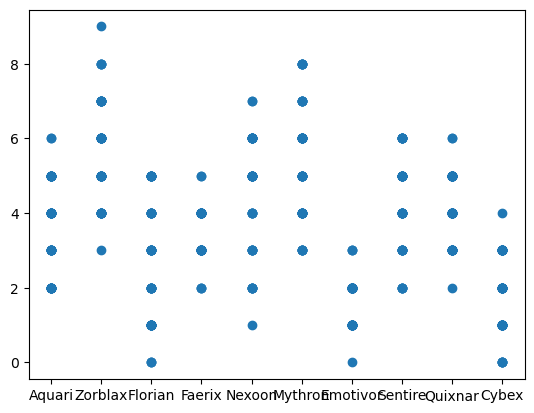

In [126]:
plt.scatter(df['species'], df['fingers'])
plt.show()

In [128]:
df1=df.groupby('species')
df1['tail'].value_counts()

species   tail
Aquari    0       44
          1        4
Cybex     0       48
          1        7
Emotivor  0       36
          1       18
Faerix    0       34
          1        9
Florian   1       43
          0        9
Mythron   1       41
          0        9
Nexoon    1       36
          0        7
Quixnar   0       46
          1       14
Sentire   1       36
          0        8
Zorblax   1       40
          0       11
Name: count, dtype: int64

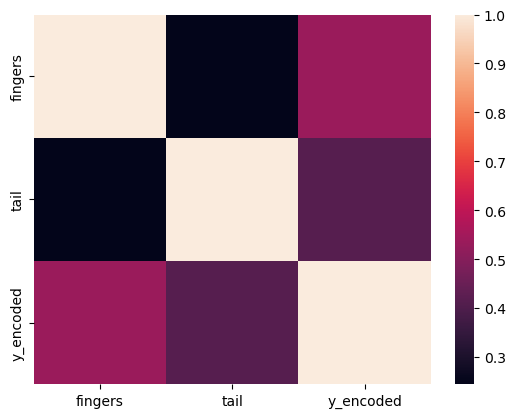

In [130]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['y_encoded'] = label_encoder.fit_transform(df['species'])
df.head()
df2=df.drop(['message'], axis=1)
df2=df2.drop(['species'], axis=1)
dataplot=sns.heatmap(df2.corr()) #heatmap for fun (and to observe correlations)

In [131]:
y=df2['y_encoded']
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.3, random_state=42)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs') #try with multinomial regression
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [134]:
df.head()
df3=df.groupby('species')
df3['y_encoded'].value_counts()

species   y_encoded
Aquari    0            48
Cybex     1            55
Emotivor  2            54
Faerix    3            43
Florian   4            52
Mythron   5            50
Nexoon    6            43
Quixnar   7            60
Sentire   8            44
Zorblax   9            51
Name: count, dtype: int64

## 4. Preparing Data for RNN

In [137]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, StandardScaler
#tokenise the words in a message
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(df['message'])
sequences = tokenizer.texts_to_sequences(df['message'])
max_len = 20  
padded_sequences = pad_sequences(sequences, maxlen=max_len)
# scaling the features (num)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['fingers', 'tail']])
# for the y to be integer instead of String
label_encoder = LabelEncoder()
alien_types = label_encoder.fit_transform(df['species'])

## 5. Implementing Recurrent Neural Network (RNN)

In [175]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
# RNN with input of the message
text_input = Input(shape=(100,))
x1 = Embedding(input_dim=10000, output_dim=64, input_length=max_len)(text_input)
x1 = LSTM(64)(x1)
features_input = Input(shape=(2,))
x2 = Dense(16, activation='relu')(features_input) # hidden layer 
combined = Concatenate()([x1, x2])
combined = Dropout(0.5)(combined)
output = Dense(10, activation='softmax')(combined) # softmax regression for the final output layer i.e. multinomial logistic regression
model = Model(inputs=[text_input, features_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #optimization and cross entropy
model.summary()

/home/547aaa54-d02d-44b7-a264-25f118ccbbe8/.local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 64)   │    640,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     33,024 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │         48 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 80)        │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 80)        │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │        810 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 673,882 (2.57 MB)

 Trainable params: 673,882 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# data split
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_sequences, scaled_features, alien_types, test_size=0.1)
# Training the model for with rnn
model.fit([X_train_text, X_train_features], y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0985 - loss: 2.3212 - val_accuracy: 0.1667 - val_loss: 2.2890
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1793 - loss: 2.2689 - val_accuracy: 0.1889 - val_loss: 2.2528
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2030 - loss: 2.2580 - val_accuracy: 0.3222 - val_loss: 2.1987
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3314 - loss: 2.1488 - val_accuracy: 0.2889 - val_loss: 2.1031
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4394 - loss: 2.0266 - val_accuracy: 0.3778 - val_loss: 1.9207
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4413 - loss: 1.8347 - val_accuracy: 0.4333 - val_loss: 1.5802
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5666 - loss: 1.4133 - val_accuracy: 0.6667 - val_loss: 1.2641
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6026 - loss: 1.1038 - val_accuracy: 0.

In [143]:
# Evaluate the model (loss and accuracy)
loss, accuracy = model.evaluate([X_test_text, X_test_features], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5817 - loss: 1.5919 
Test Loss: 1.6296769380569458, Test Accuracy: 0.5600000023841858


## 6. Using Classification Method

In [144]:
df. head()

,message,fingers,tail,species,y_encoded
0,pluvia arbor aquos,4,0,Aquari,0
1,cosmix xeno nebuz odbitaz,5,1,Zorblax,9
2,solarix glixx novum galaxum quasar,5,1,Zorblax,9
3,arbor insectus pesros ekos dootix nimbus,2,1,Florian,4
4,mermax drakos lorix epikoz deftax,4,0,Faerix,3


In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

Accuracy: 80.00%


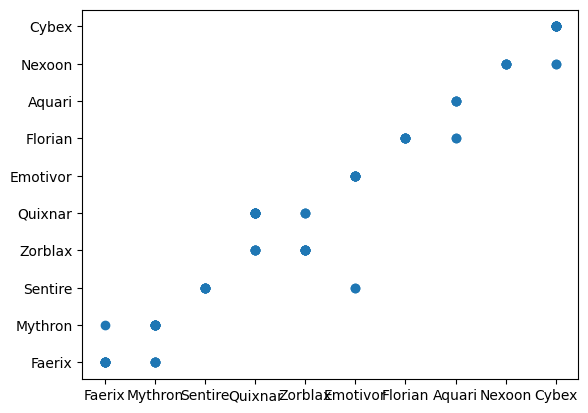

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
# redo data processing 
# vectorisation of text
train_data = pd.read_csv('data.csv')
train_data['tail'] = train_data['tail'].apply(lambda x: 1 if x == 'yes' else 0)
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(df['message'])
# prepping the training set
X_train = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), df[['fingers', 'tail']]], axis=1)
y_train = train_data['species']
X_train.columns = [str(i) for i in X_train.columns]
# splitting the set to train and test
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)
# random forest classifier model
clf = RandomForestClassifier()
clf.fit(X_train_split, y_train_split)
val_predictions = clf.predict(X_val)
plt.scatter(val_predictions, y_val)

# evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(val_predictions, y_val)
print(f'Accuracy: {accuracy * 100:.2f}%')

In [152]:
test_data=pd.read_csv('test (2).csv')
test_data.head()

,message,fingers,tail
0,iephyr terram nimbus terram faunar foliar,2,no
1,joyzor uleex luvium caloox shockus blissae,4,yes
2,aquos arbor ventuc,4,yes
3,nympha nympha epikoz nympha mythox mythox mythox,3,no
4,diitax sibenix fabulon,4,yes


In [156]:
test_data['tail'] = test_data['tail'].apply(lambda x: 1 if x == 'yes' else 0)
# the test set
tfidf = TfidfVectorizer(max_features=1000)
X_test_tfidf = tfidf.fit_transform(df['message'])
# predicting the model on the test set given
X_test = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), df[['fingers', 'tail']]], axis=1)
X_test.columns = [str(i) for i in X_test.columns]
val_predictions = clf.predict(X_val)

In [158]:
print(val_predictions)

['Faerix' 'Mythron' 'Sentire' 'Faerix' 'Quixnar' 'Zorblax' 'Zorblax'
 'Quixnar' 'Emotivor' 'Quixnar' 'Sentire' 'Florian' 'Faerix' 'Mythron'
 'Aquari' 'Mythron' 'Emotivor' 'Zorblax' 'Mythron' 'Emotivor' 'Nexoon'
 'Faerix' 'Cybex' 'Faerix' 'Florian' 'Faerix' 'Quixnar' 'Cybex' 'Faerix'
 'Sentire' 'Cybex' 'Faerix' 'Mythron' 'Sentire' 'Quixnar' 'Zorblax'
 'Emotivor' 'Mythron' 'Florian' 'Quixnar' 'Cybex' 'Mythron' 'Nexoon'
 'Nexoon' 'Sentire' 'Zorblax' 'Aquari' 'Emotivor' 'Cybex' 'Cybex'
 'Emotivor' 'Quixnar' 'Quixnar' 'Florian' 'Florian' 'Mythron' 'Quixnar'
 'Cybex' 'Emotivor' 'Quixnar' 'Cybex' 'Zorblax' 'Aquari' 'Cybex' 'Mythron'
 'Cybex' 'Emotivor' 'Mythron' 'Mythron' 'Nexoon' 'Aquari' 'Aquari'
 'Emotivor' 'Zorblax' 'Mythron' 'Florian' 'Mythron' 'Quixnar' 'Cybex'
 'Faerix' 'Sentire' 'Quixnar' 'Quixnar' 'Florian' 'Nexoon' 'Zorblax'
 'Zorblax' 'Faerix' 'Zorblax' 'Cybex' 'Emotivor' 'Aquari' 'Sentire'
 'Zorblax' 'Quixnar' 'Cybex' 'Quixnar' 'Quixnar' 'Cybex' 'Mythron']


In [160]:
val_predictions_array=np.array(val_predictions) # to array

In [164]:
final = pd.DataFrame(val_predictions_array, columns=['predicted_y'])
final.head() # converting to dataframe

,predicted_y
0,Faerix
1,Mythron
2,Sentire
3,Faerix
4,Quixnar


In [171]:
final.to_csv('final_thing.csv', index=False) # to csv, over and out